In [5]:
import pandas as pd

In [6]:
df = pd.read_excel("../data/raw/online_retail.xlsx", decimal=",")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
import os
os.getcwd()

'C:\\Users\\User\\Documents\\business-performance-analytics\\notebooks'

In [9]:
df.shape

(541909, 8)

In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
## Data Overview 
## This section provides an initial overview of the dataset, including its structure,
## data types, and potential data quality issues that may impact the analysis.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [13]:
df.duplicated().sum()

5268

In [14]:
(df["Quantity"] <= 0).sum()

10624

In [15]:
(df["UnitPrice"] <= 0).sum()

2517

In [16]:
## Initial data quality checks reveal the presence of cancellations, zero or negative quantities,
## and missing customer identifiers. These issues will be addressed in the data cleaning phase,
## as they may affect revenue calculations and customer-level analysis.

In [17]:
## Data Cleaning Rationale

In [18]:
## Before performing analysis, several data quality issues need to be addressed.
## These include cancellations, negative or zero quantities, missing customer identifiers,
## and inconsistent data types. The cleaning steps below aim to ensure that the analysis
## reflects actual business activity and meaningful customer behavior.

In [19]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [20]:
df["InvoiceDate"].dtype

dtype('<M8[ns]')

In [21]:
df["is_cancellation"] = df["InvoiceNo"].astype(str).str.startswith("C")

In [22]:
df["is_cancellation"].value_counts()

is_cancellation
False    532621
True       9288
Name: count, dtype: int64

In [23]:
## Starting with "С" - cancelled orders (9288)

In [24]:
df_clean = df[
    (df["Quantity"] > 0) &
    (df["UnitPrice"] > 0) &
    (~df["is_cancellation"])
].copy()

In [25]:
df_clean["CustomerID"].isnull().sum()

132220

In [26]:
## Some transactions do not contain a customer identifier.
## These records will be retained for overall revenue analysis
## but excluded from customer-level segmentation.

In [27]:
## Revenue (line)

In [28]:
df_clean["Revenue"] = df_clean["Quantity"] * df_clean["UnitPrice"]

In [29]:
df_clean["Revenue"].describe()

count    530104.000000
mean         20.121871
std         270.356743
min           0.001000
25%           3.750000
50%           9.900000
75%          17.700000
max      168469.600000
Name: Revenue, dtype: float64

In [30]:
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

df_clean["Year"] = df_clean["InvoiceDate"].dt.year
df_clean["Month"] = df_clean["InvoiceDate"].dt.month
df_clean["Day"] = df_clean["InvoiceDate"].dt.day

In [31]:
## Key Performance Indicators (KPIs)

## The following KPIs provide an initial view of the company’s business performance
## and will guide further analysis.

In [32]:
## Total revenue 

In [33]:
total_revenue = df_clean["Revenue"].sum()
total_revenue

10666684.544

In [34]:
## Number of orders

In [35]:
total_orders = df_clean["InvoiceNo"].nunique()
total_orders

19960

In [36]:
## Number of customers (unique)

In [37]:
unique_customers = df_clean["CustomerID"].nunique()
unique_customers

4338

In [38]:
## Average order value

In [39]:
aov = total_revenue / total_orders
aov

534.403033266533

In [40]:
## Cancellation rate

In [41]:
cancellation_rate = df["is_cancellation"].mean()
cancellation_rate

0.017139409015166755

In [42]:
### Initial Observations

## The dataset includes over 540,000 transactions, providing a solid basis for reliable analysis.
## Approximately 1.7% of transactions are cancellations, which may have a significant impact on overall performance.
## Revenue distribution is highly distorted, with a small share of orders generating a disproportionate amount of total revenue.
## Missing customer identifiers affect customer-level analysis but do not impact aggregate revenue and order benchmarks.

In [43]:
## Orders-level aggregation

In [44]:
orders = (
    df_clean
    .groupby("InvoiceNo")
    .agg(
        order_revenue=("Revenue", "sum"),
        order_items=("Quantity", "sum"),
        customer_id=("CustomerID", "first"),
        order_date=("InvoiceDate", "first")
    )
    .reset_index()
)

In [45]:
## Dirtibution of the orders

In [46]:
orders["order_revenue"].describe()

count     19960.000000
mean        534.403033
std        1780.487648
min           0.380000
25%         152.510000
50%         303.835000
75%         495.615000
max      168469.600000
Name: order_revenue, dtype: float64

In [47]:
## Top clients

In [48]:
customer_revenue = (
    df_clean
    .groupby("CustomerID")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

In [49]:
customer_revenue.head(10)

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
12415.0    124914.53
14156.0    117379.63
17511.0     91062.38
16029.0     81024.84
12346.0     77183.60
Name: Revenue, dtype: float64

In [50]:
## The share of top clients

In [51]:
top_10_share = customer_revenue.head(10).sum() / customer_revenue.sum()
top_10_share

0.17261881248972175

In [52]:
## Order and Customer-Level Insights

In [53]:
## Order-level analysis shows a distorted revenue distribution.
## While the median order value is approximately £304, the average order value exceeds £500,
## indicating the presence of large wholesale transactions.

In [54]:
## Customer-level aggregation submits strong revenue concentration.
## The top 10 customers generate approximately 17% of total revenue,
## highlighting a business model highly dependent on a small number of high-value clients.

In [55]:
## Time aggregation

In [56]:
monthly_revenue = (
    df_clean
    .groupby(["Year", "Month"])["Revenue"]
    .sum()
    .reset_index()
)

In [58]:
monthly_revenue["Date"] = pd.to_datetime(
    monthly_revenue["Year"].astype(str) + "-" + monthly_revenue["Month"].astype(str)
)


In [60]:
monthly_revenue.sort_values("Date").head()

,Year,Month,Revenue,Date
0,2010,12,823746.140,2010-12-01
1,2011,1,691364.560,2011-01-01
2,2011,2,523631.890,2011-02-01
3,2011,3,717639.360,2011-03-01
4,2011,4,537808.621,2011-04-01


In [61]:
monthly_revenue.sort_values("Date").tail()

,Year,Month,Revenue,Date
8,2011,8,759138.380,2011-08-01
9,2011,9,1058590.172,2011-09-01
10,2011,10,1154979.300,2011-10-01
11,2011,11,1509496.330,2011-11-01
12,2011,12,638792.680,2011-12-01


In [62]:
## Time-Based Trends

In [63]:
## Monthly revenue analysis reveals clear fluctuations over time,
## suggesting the presence of seasonality and demand peaks.
## Further analysis will focus on identifying high-performing periods
## and potential drivers of revenue volatility.

In [66]:
## SQL part

In [64]:
import sqlite3

In [65]:
conn = sqlite3.connect("analytics.db")
df_clean.to_sql("transactions", conn, if_exists="replace", index=False)

530104

In [ ]:
## Total revenue

In [67]:
query = """
SELECT SUM(Revenue) AS total_revenue
FROM transactions;
"""
pd.read_sql(query, conn)

,total_revenue
0,1.066668e+07


In [69]:
## Top clients

In [68]:
query = """
SELECT CustomerID, SUM(Revenue) AS customer_revenue
FROM transactions
GROUP BY CustomerID
ORDER BY customer_revenue DESC
LIMIT 10;
"""
pd.read_sql(query, conn)

,CustomerID,customer_revenue
0,NaN,1755276.64
1,14646.0,280206.02
2,18102.0,259657.30
3,17450.0,194550.79
4,16446.0,168472.50
5,14911.0,143825.06
6,12415.0,124914.53
7,14156.0,117379.63
8,17511.0,91062.38
9,16029.0,81024.84


In [70]:
## Revenue by months

In [71]:
query = """
SELECT
    strftime('%Y-%m', InvoiceDate) AS month,
    SUM(Revenue) AS monthly_revenue
FROM transactions
GROUP BY month
ORDER BY month;
"""
pd.read_sql(query, conn)

,month,monthly_revenue
0,2010-12,1462538.820
1,2011-01,691364.560
2,2011-02,523631.890
3,2011-03,717639.360
4,2011-04,537808.621
5,2011-05,770536.020
6,2011-06,761739.900
7,2011-07,719221.191
8,2011-08,759138.380
9,2011-09,1058590.172


In [72]:
## SQL-Based Validation

In [73]:
## Monthly revenue analysis shows clear fluctuations over time, with a strong increase toward the end of 2011
## and a pronounced peak in November, indicating seasonality typical for retail and wholesale businesses.

In [74]:
## Total revenue figures are consistent across both approaches, confirming calculation accuracy.
## Customer-level SQL aggregation highlights revenue concentration, including transactions without customer identifiers,
## which were retained for aggregate analysis.

In [75]:
## Visualisation

In [76]:
## Revenue over Time

In [77]:
import matplotlib.pyplot as plt

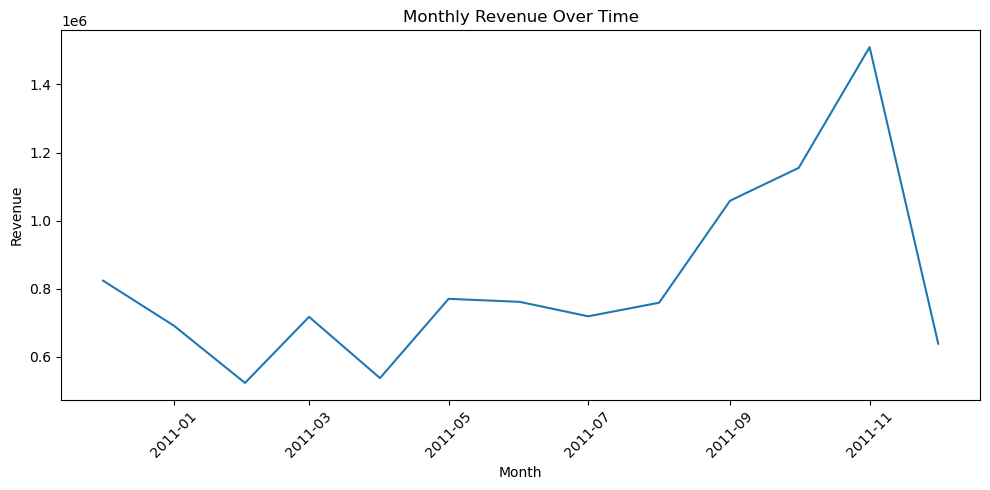

In [78]:
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue["Date"], monthly_revenue["Revenue"])
plt.title("Monthly Revenue Over Time")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
## Revenue concentration

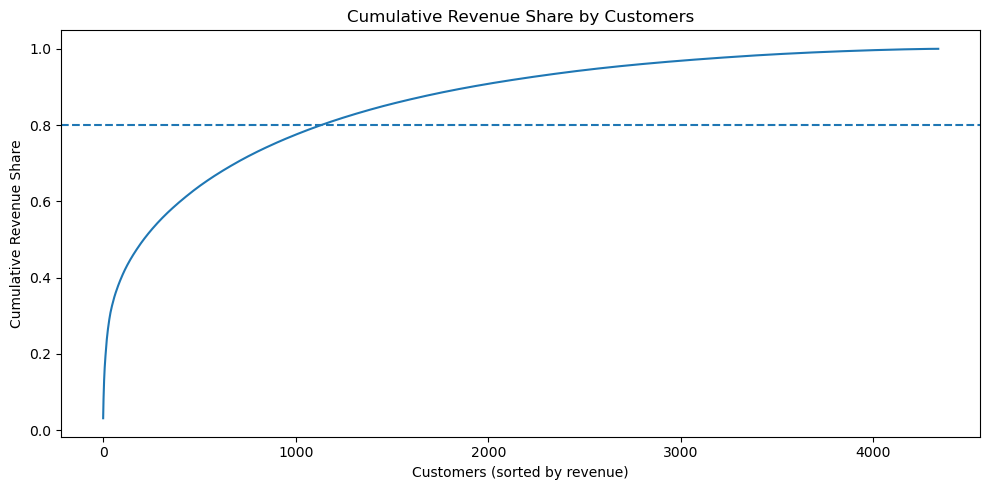

In [80]:
customer_revenue_sorted = customer_revenue.sort_values(ascending=False)
cumulative_share = customer_revenue_sorted.cumsum() / customer_revenue_sorted.sum()

plt.figure(figsize=(10,5))
plt.plot(cumulative_share.values)
plt.axhline(0.8, linestyle="--")
plt.title("Cumulative Revenue Share by Customers")
plt.xlabel("Customers (sorted by revenue)")
plt.ylabel("Cumulative Revenue Share")
plt.tight_layout()
plt.show()

In [81]:
## Orders vs Revenue Distribution

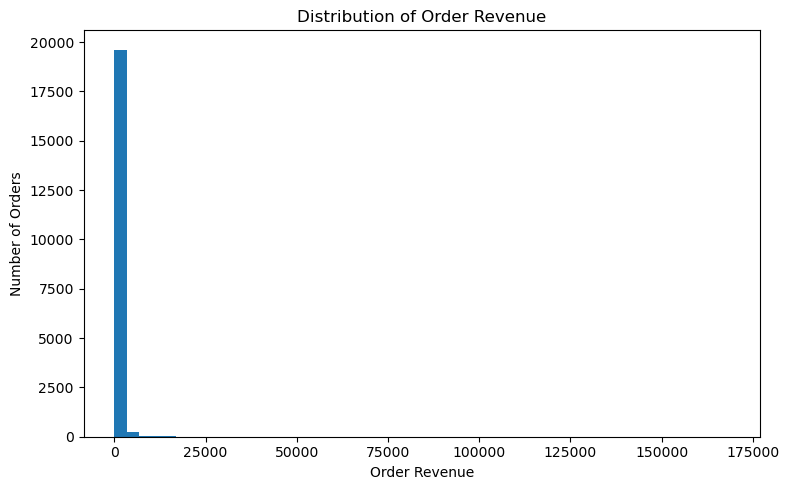

In [82]:
plt.figure(figsize=(8,5))
plt.hist(orders["order_revenue"], bins=50)
plt.title("Distribution of Order Revenue")
plt.xlabel("Order Revenue")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

In [83]:
## Visual insights

In [84]:
## Monthly revenue trends show clear seasonality, with a strong upward trajectory toward the end of 2011
## and a pronounced peak in November, followed by a sharp decline in December.

In [85]:
## Cumulative revenue analysis highlights significant customer concentration.
## A relatively small proportion of customers accounts for the majority of total revenue,
## indicating a strong dependence on high-value clients.

In [86]:
## Order revenue distribution is highly right-skewed.
## Most orders are of relatively low value, while a small number of large transactions
## contribute disproportionately to overall revenue, consistent with a wholesale-oriented business model.

In [88]:
import os

os.makedirs("../data/processed", exist_ok=True)

In [89]:
df_clean.to_csv(
    "../data/processed/transactions_clean.csv",
    index=False
)

In [90]:
os.listdir("../data/processed")

['transactions_clean.csv']